In [30]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/demo/Desktop/COGS118B_WI_24/Project/archive/ISIC_2019_Training_GroundTruth.csv", header = 0)
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC' : 'Squamous cell carcinoma'
}
data['truth'] = data.drop(columns='image').idxmax(axis=1)
data.head(20)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,truth
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
def load_data(path: str):
    dir = Path(path)
    filepaths = list(dir.glob(r'**/*.jpg'))
    labels = data['truth']
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    labels = pd.Series(labels, name='Labels').astype(str)
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    return df.sample(frac=1).reset_index(drop=True)
df = load_data('/Users/demo/Desktop/COGS118B_WI_24/Project/archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

In [5]:
df.head(20)

,FilePaths,Labels
0,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BCC
1,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
2,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BCC
3,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,MEL
4,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
5,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,MEL
6,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
7,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
8,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BKL
9,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,DF


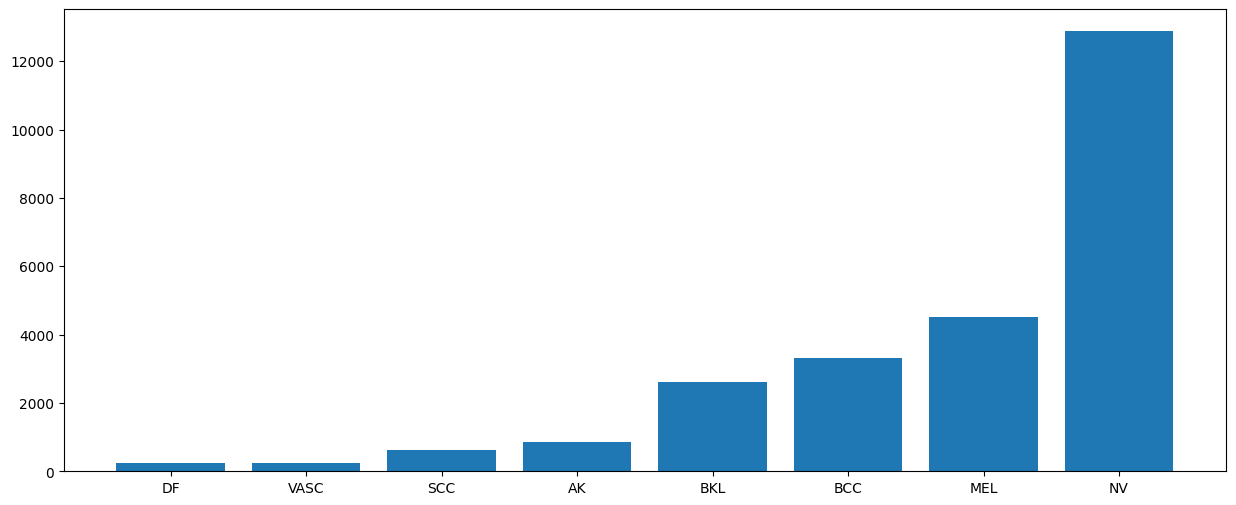

In [6]:
labels_count = df['Labels'].value_counts(ascending=True)

plt.figure(figsize=(15, 6))
plt.bar(labels_count.index, labels_count.values)
plt.show()

In [7]:
df['Labels'] = df['Labels'].apply(lambda x: x if x == 'NV' else 'OTH')
df_binary = df['Labels']
binary = np.array([-1 if x == 'OTH' else 1 for x in df_binary])
binary.shape

(25331,)

We can see that our data is heavily biased towards NV, and has low numbers of other diseases

In [8]:
files = pd.read_csv('archive/ISIC_2019_Training_GroundTruth.csv')
files

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
filesWithLabels = pd.DataFrame()
filesWithLabels['file'] = files['image']+'.jpg'
filesWithLabels['label'] = ""

In [10]:
filesWithLabels['label'] = data['truth']
filesWithLabels['file'] = 'archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+filesWithLabels['file']

In [29]:
X_train, X_test = train_test_split(filesWithLabels, test_size=0.2, random_state=42)

In [31]:
X_train

,file,label
24937,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,AK
12362,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
4223,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
1355,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
16166,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,BCC
...,...,...
21575,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
5390,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
860,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,MEL
15795,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV


In [32]:
epochs = 5
input_shape = (128, 128, 3)
num_classes = 1
def get_model():   

    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(256, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])
    return model

In [33]:
datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=0.2,
    rotation_range=20,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, 
    vertical_flip=True,
    fill_mode="nearest",
)
def plot_history(history, title):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.title(title)
    plt.show()

In [49]:
def conver_models(model,name):
    dest_folder = '/kaggle/working/'
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(dest_folder  + name +".tflite", 'wb') as f:
        f.write(tflite_model)
def create_model(table, name, epoch):
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    train_generator = datagen.flow_from_dataframe(
        dataframe=table,
        directory=None,
        x_col='file',
        y_col='label',
        subset="training",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="binary",
        target_size=(128, 128))
    validation_generator = datagen.flow_from_dataframe(
        dataframe=table,
        directory=None,
        x_col='file',
        y_col='label',
        subset="validation",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="binary",
        target_size=(128, 128))
    # Create a function that yields samples
    model = get_model()
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epoch, validation_data=validation_generator, callbacks=[early_stop])
    return history, model     

In [50]:
NVTable = pd.concat([X_train.loc[X_train['label'] != 'NV'].sample(n=8000), X_train.loc[X_train['label'] == 'NV']])
NVTable['label'] = NVTable['label'].apply(lambda x: 'OTH' if x != 'NV' else x)

n = X_train.loc[X_train['label'] == 'MEL'].shape[0]
MELTable = pd.concat([X_train.loc[X_train['label'] != 'MEL'].sample(n=n), X_train.loc[X_train['label'] == 'MEL']])
MELTable['label'] = MELTable['label'].apply(lambda x: 'OTH' if x != 'MEL' else x)

n = X_train.loc[X_train['label'] == 'BKL'].shape[0]
BKLTable = pd.concat([X_train.loc[X_train['label'] != 'BKL'].sample(n=n), X_train.loc[X_train['label'] == 'BKL']])
BKLTable['label'] = BKLTable['label'].apply(lambda x: 'OTH' if x != 'BKL' else x)

n = X_train.loc[X_train['label'] == 'DF'].shape[0]
DFTable = pd.concat([X_train.loc[X_train['label'] != 'DF'].sample(n=n), X_train.loc[X_train['label'] == 'DF']])
DFTable['label'] = DFTable['label'].apply(lambda x: 'OTH' if x != 'DF' else x)

n = X_train.loc[X_train['label'] == 'SCC'].shape[0]
SCCTable = pd.concat([X_train.loc[X_train['label'] != 'SCC'].sample(n=n), X_train.loc[X_train['label'] == 'SCC']])
SCCTable['label'] = SCCTable['label'].apply(lambda x: 'OTH' if x != 'SCC' else x)

n = X_train.loc[X_train['label'] == 'BCC'].shape[0]
BCCTable = pd.concat([X_train.loc[X_train['label'] != 'BCC'].sample(n=n), X_train.loc[X_train['label'] == 'BCC']])
BCCTable['label'] = BCCTable['label'].apply(lambda x: 'OTH' if x != 'BCC' else x)

n = X_train.loc[X_train['label'] == 'VASC'].shape[0]
VASCTable = pd.concat([X_train.loc[filesWithLabels['label'] != 'VASC'].sample(n=n), X_train.loc[X_train['label'] == 'VASC']])
VASCTable['label'] = VASCTable['label'].apply(lambda x: 'OTH' if x != 'VASC' else x)

n = X_train.loc[X_train['label'] == 'AK'].shape[0]
AKTable = pd.concat([X_train.loc[X_train['label'] != 'AK'].sample(n=n), X_train.loc[X_train['label'] == 'AK']])
AKTable['label'] = AKTable['label'].apply(lambda x: 'OTH' if x != 'AK' else x)

tables = {
    "AK": AKTable,
    "NV": NVTable,
    "MEL": MELTable,
    "BKL": BKLTable,
    "DF": DFTable,
    "SCC": SCCTable,
    "BCC": BCCTable,
    "VASC": VASCTable,

}

Found 1104 validated image filenames belonging to 2 classes.


Found 276 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6106 - loss: 1.0833 - val_accuracy: 0.9638 - val_loss: 0.4234
Epoch 2/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6869 - loss: 0.7017 - val_accuracy: 0.0362 - val_loss: 1.2951
Epoch 3/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7518 - loss: 0.5533 - val_accuracy: 0.2283 - val_loss: 1.0010
Epoch 4/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7507 - loss: 0.5337 - val_accuracy: 0.2500 - val_loss: 0.9751
Epoch 5/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7600 - loss: 0.5686 - val_accuracy: 0.3370 - val_loss: 0.9900
Epoch 6/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7603 - loss: 0.5717 - val_accuracy: 0.3225 - val_loss: 1.3672
Found 1380 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 973ms/step - accuracy: 0.4665 - loss: 1.1139
Test Loss: 0.7432914972305298, Test Accuracy: 0.665217399597168


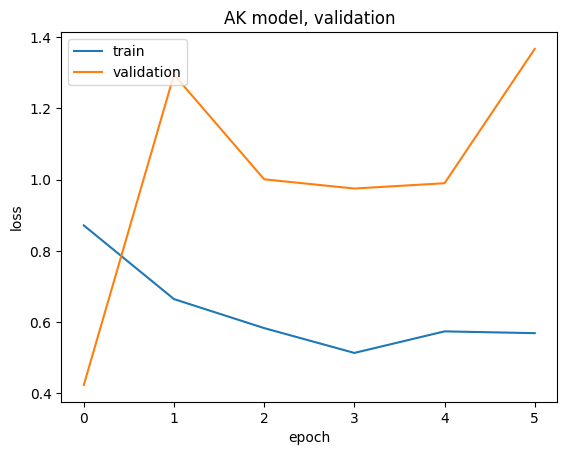

Found 14647 validated image filenames belonging to 2 classes.
Found 3661 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/229 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.7022 - loss: 0.7241 - val_accuracy: 0.5955 - val_loss: 0.9283
Epoch 2/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7590 - loss: 0.5135 - val_accuracy: 0.4428 - val_loss: 1.1970
Epoch 3/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7735 - loss: 0.4674 - val_accuracy: 0.2180 - val_loss: 1.1786
Epoch 4/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7913 - loss: 0.4432 - val_accuracy: 0.2950 - val_loss: 1.6028
Epoch 5/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.8064 - loss: 0.4217 - val_accuracy: 0.5594 - val_loss: 0.7810
Epoch 6/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8028 - loss: 0.4197 - val_accuracy: 0.5703 - val_loss: 0.8784
Epoch 7/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8042 - loss: 0.4193 - val_accuracy: 0.6719 - val_loss: 0.6679
Found 18308 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 283s 986ms/step - accuracy: 0.7176 - loss: 0.5904
Test Loss: 0.4485863447189331, Test Accuracy: 0.7920035123825073


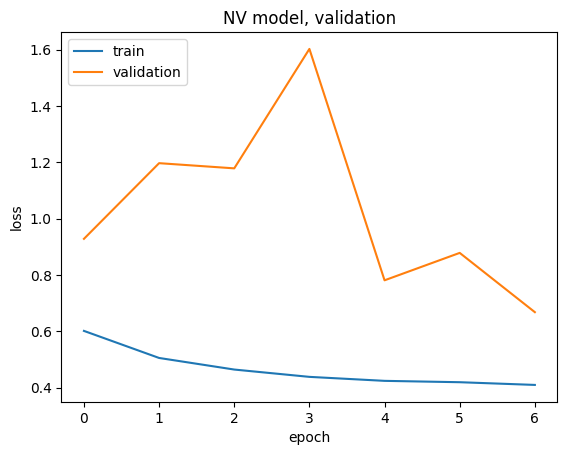

Found 5772 validated image filenames belonging to 2 classes.
Found 1442 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5900 - loss: 0.9937 - val_accuracy: 0.7753 - val_loss: 0.4812
Epoch 2/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6539 - loss: 0.6838 - val_accuracy: 0.6602 - val_loss: 0.6149
Epoch 3/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6708 - loss: 0.6375 - val_accuracy: 0.5707 - val_loss: 0.7799
Epoch 4/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6649 - loss: 0.6178 - val_accuracy: 0.8356 - val_loss: 0.5220
Epoch 5/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6863 - loss: 0.5936 - val_accuracy: 0.4237 - val_loss: 1.4809
Epoch 6/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7061 - loss: 0.5834 - val_accuracy: 0.4813 - val_loss: 0.7246
Found 7214 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 109s 968ms/step - accuracy: 0.5403 - loss: 0.6856
Test Loss: 0.5822501182556152, Test Accuracy: 0.6729969382286072


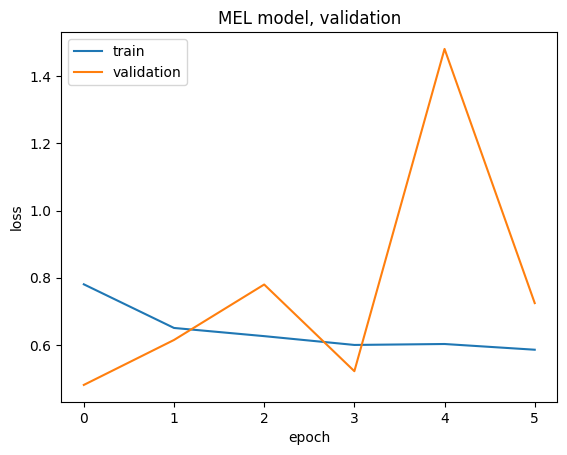

Found 3341 validated image filenames belonging to 2 classes.
Found 835 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5835 - loss: 1.1001 - val_accuracy: 0.9796 - val_loss: 0.1157
Epoch 2/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6558 - loss: 0.6753 - val_accuracy: 0.9904 - val_loss: 0.0980
Epoch 3/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6758 - loss: 0.6443 - val_accuracy: 0.7844 - val_loss: 0.4035
Epoch 4/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6658 - loss: 0.6679 - val_accuracy: 0.3820 - val_loss: 1.0292
Epoch 5/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6706 - loss: 0.6301 - val_accuracy: 0.7689 - val_loss: 0.4810
Epoch 6/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6998 - loss: 0.6064 - val_accuracy: 0.6419 - val_loss: 0.6504
Epoch 7/7
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6814 - loss: 0.6225 - val_accuracy: 0.5126 - val_loss: 0.7663
Found 4176 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5607 - loss: 0.6968
Test Loss: 0.5993062257766724, Test Accuracy: 0.6673850417137146


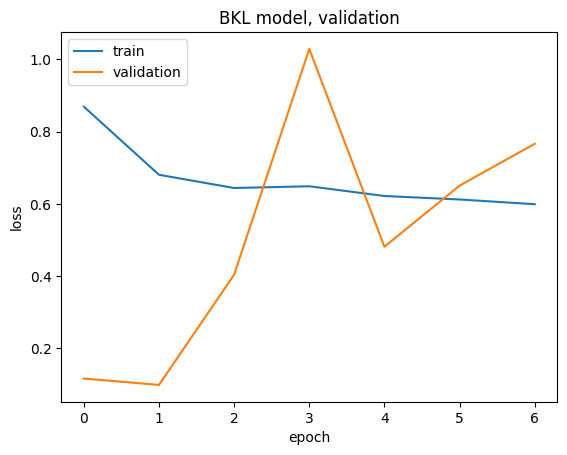

Found 306 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6250 - loss: 1.2742 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 891ms/step - accuracy: 0.6334 - loss: 0.8210 - val_accuracy: 0.0000e+00 - val_loss: 2.5796
Epoch 3/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 889ms/step - accuracy: 0.6934 - loss: 0.7350 - val_accuracy: 0.3553 - val_loss: 0.8051
Epoch 4/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 918ms/step - accuracy: 0.6754 - loss: 0.7248 - val_accuracy: 0.1053 - val_loss: 1.1006
Epoch 5/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 922ms/step - accuracy: 0.6989 - loss: 0.6531 - val_accuracy: 0.2763 - val_loss: 0.8541
Epoch 6/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 923ms/step - accuracy: 0.6972 - loss: 0.6452 - val_accuracy: 0.9737 - val_loss: 0.3467
Found 382 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 961ms/step - accuracy: 0.7579 - loss: 0.5611
Test Loss: 0.7879155278205872, Test Accuracy: 0.5052356123924255


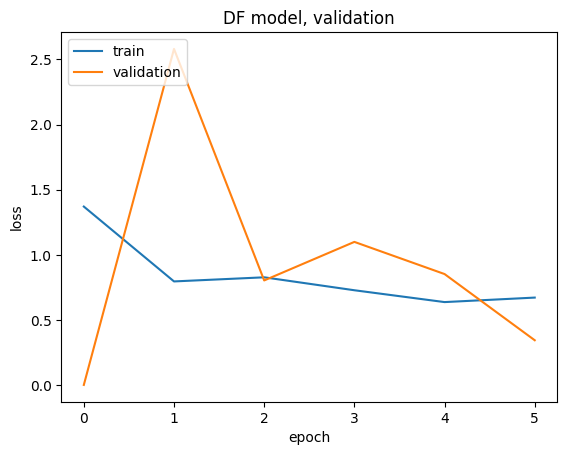

Found 839 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5633 - loss: 1.4109 - val_accuracy: 0.7321 - val_loss: 0.5462
Epoch 2/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6930 - loss: 0.6716 - val_accuracy: 0.0622 - val_loss: 2.0531
Epoch 3/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6785 - loss: 0.6967 - val_accuracy: 0.8756 - val_loss: 0.3017
Epoch 4/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6861 - loss: 0.6930 - val_accuracy: 0.2967 - val_loss: 1.1780
Epoch 5/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7319 - loss: 0.6043 - val_accuracy: 0.3732 - val_loss: 1.6161
Epoch 6/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7220 - loss: 0.6024 - val_accuracy: 0.1722 - val_loss: 2.1944
Epoch 7/7
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7130 - loss: 0.5950 - val_accuracy: 0.6124 - val_loss: 0.7031
Found 1048 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 970ms/step - accuracy: 0.6152 - loss: 0.6826
Test Loss: 0.6582521796226501, Test Accuracy: 0.6479007601737976


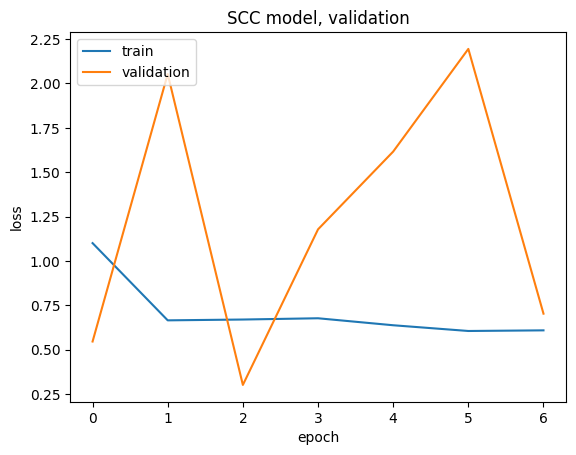

Found 4264 validated image filenames belonging to 2 classes.
Found 1066 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6729 - loss: 0.8255 - val_accuracy: 0.8180 - val_loss: 0.3269
Epoch 2/7
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7394 - loss: 0.5971 - val_accuracy: 0.7242 - val_loss: 0.4461
Epoch 3/7
67/67 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7771 - loss: 0.5037 - val_accuracy: 0.6942 - val_loss: 0.5455
Epoch 4/7
67/67 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7992 - loss: 0.4773 - val_accuracy: 0.7824 - val_loss: 0.4249
Epoch 5/7
67/67 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8035 - loss: 0.4659 - val_accuracy: 0.7645 - val_loss: 0.4386
Epoch 6/7
67/67 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8006 - loss: 0.4616 - val_accuracy: 0.5732 - val_loss: 0.9002
Found 5330 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6131 - loss: 0.8236
Test Loss: 0.5978004336357117, Test Accuracy: 0.7380862832069397


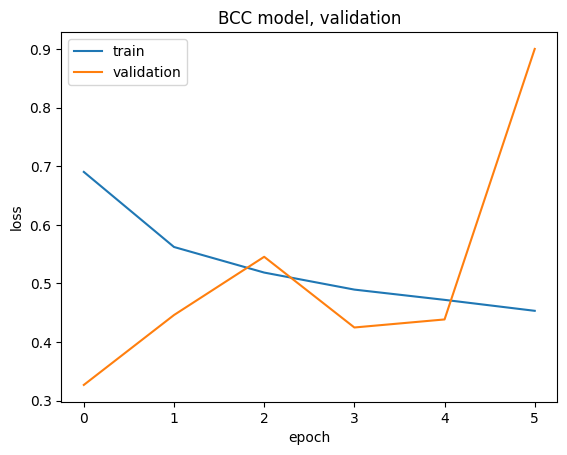

Found 306 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/7


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5845 - loss: 0.9867 - val_accuracy: 0.3816 - val_loss: 1.0144
Epoch 2/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 778ms/step - accuracy: 0.7129 - loss: 0.6061 - val_accuracy: 1.0000 - val_loss: 0.0795
Epoch 3/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 776ms/step - accuracy: 0.7797 - loss: 0.5688 - val_accuracy: 0.9737 - val_loss: 0.4561
Epoch 4/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 780ms/step - accuracy: 0.6745 - loss: 0.5913 - val_accuracy: 1.0000 - val_loss: 0.3063
Epoch 5/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 832ms/step - accuracy: 0.7758 - loss: 0.5394 - val_accuracy: 0.9737 - val_loss: 0.2748
Epoch 6/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 787ms/step - accuracy: 0.7640 - loss: 0.4551 - val_accuracy: 0.6711 - val_loss: 0.6659
Epoch 7/7
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 834ms/step - accuracy: 0.7566 - loss: 0.5503 - val_accuracy: 0.5526 - val_loss: 0.6540
Found 382 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 919ms/step - accuracy: 0.6313 - loss: 0.6389
Test Loss: 0.5969861745834351, Test Accuracy: 0.6937173008918762


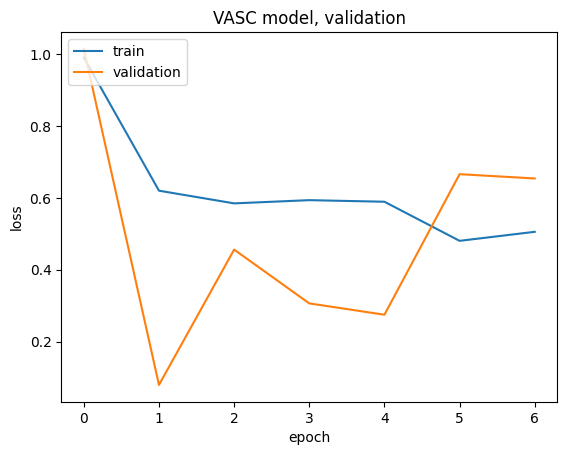

In [51]:
for i in tables.keys():
    hist_1, mdl_1 = create_model(tables[i], str(i) + " model, validation", 7)
    test_generator = datagen.flow_from_dataframe(
        dataframe=tables[i],  # Your test DataFrame
        directory=None,  # Adjust if your file paths are relative
        x_col='file',  # Column in X_test that contains the file paths
        y_col='label',  # Column in X_test that contains the labels
        batch_size=64,  # Can adjust based on your preference
        seed=42,
        shuffle=False,  # Keep it False to maintain order, important for evaluation
        class_mode="binary",  # or "categorical" based on your model
        target_size=(128, 128)
        )
    eval_result = mdl_1.evaluate(test_generator)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")
    plot_history(hist_1, str(i) + " model, validation loss")